### Image Classification using EfficientNet

##### 1. **Import Libraries**

In [1]:
import os
import re
import random
import cv2
import imutils

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator, array_to_img
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense

##### 2. **Prepare directories for data**
This code segment is designed to clean and organize a dataset of images. It first iterates through the folders in the specified dataset directory (data_dir), checking for and removing any duplicate images based on a regular expression pattern that matches filenames ending with "(1)", "(2)", "(3)", etc. After cleaning the dataset, it creates a directory structure for training and testing data. Specifically, it ensures the existence of main directories (train_dir and test_dir) and then creates subdirectories within these main directories for each class found in the dataset. This setup organizes the data into a clear structure for subsequent training and testing phases of a machine learning model.

In [36]:
data_dir = '../../dataset_26'

# Regular expression pattern to match filenames ending with (1), (2), (3), etc.
pattern = re.compile(r'\(\d+\)\.\w+$')

# Iterate over each folder in the dataset
for folder in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder)
    
    # Check if the path is a directory
    if os.path.isdir(folder_path):
        # Iterate over the images in the folder
        for image in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image)
            
            # Check if the filename matches the pattern
            if pattern.search(image):
                # Remove the duplicate image
                os.remove(image_path)

train_dir = 'content/Train-Data'
test_dir = 'content/Test-Data'

classes = os.listdir(data_dir) 

# Create main directories if they do not exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Create subdirectories for each class if they do not exist
for cls in classes:
    os.makedirs(f'{train_dir}/{cls}', exist_ok=True)
    os.makedirs(f'{test_dir}/{cls}', exist_ok=True)

In [3]:
classes

['glioma', 'meningioma', 'notumor', 'pituitary']

##### 3. **Visualise the data**

In [4]:
train_files_path = {cls: list(map(lambda x: os.path.join(data_dir, cls, x), os.listdir(os.path.join(data_dir, cls)))) for cls in classes}

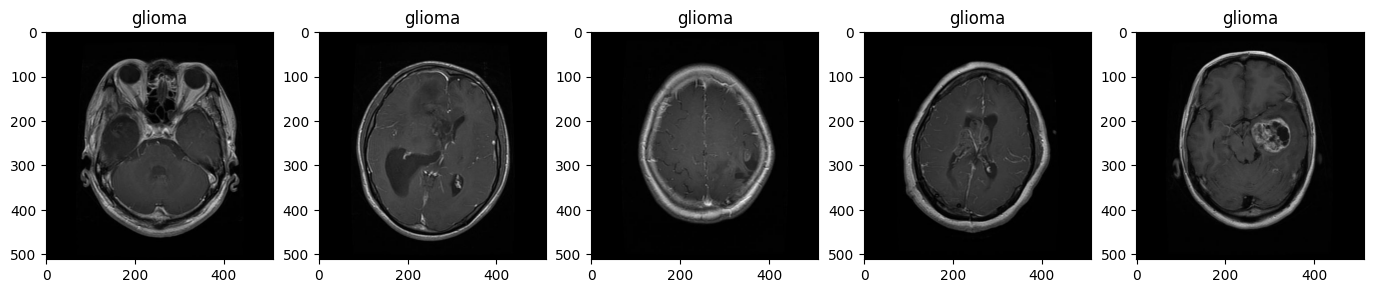

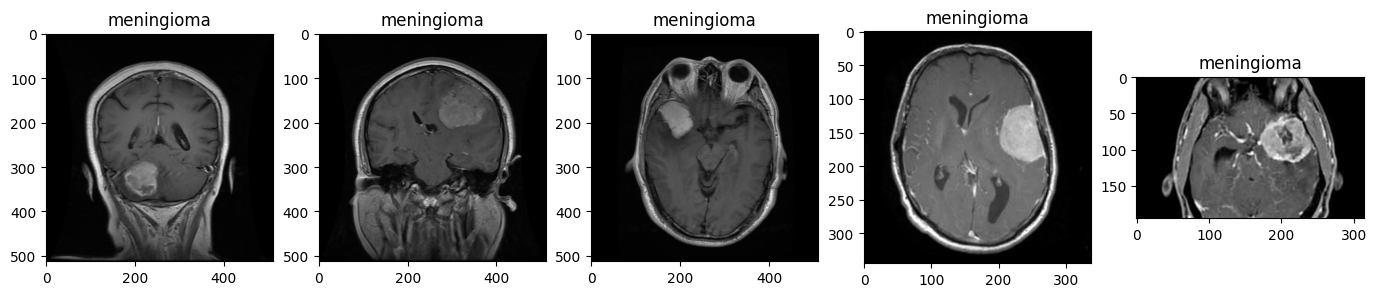

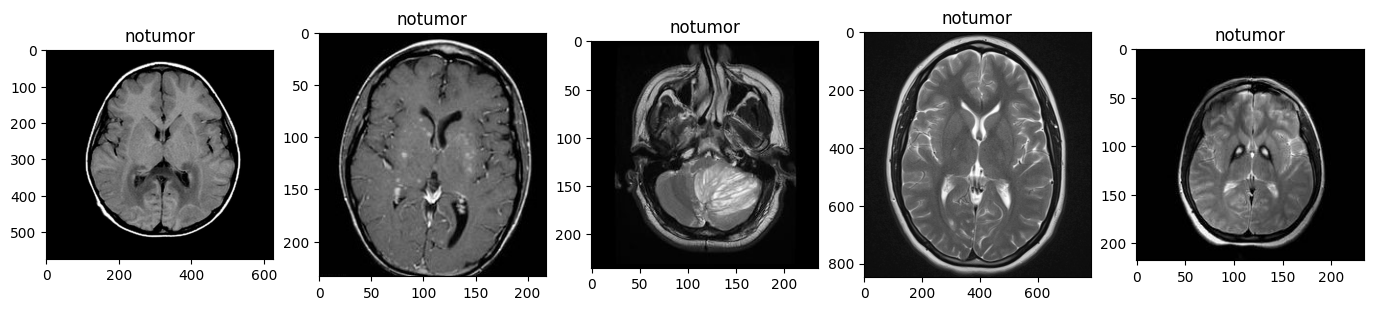

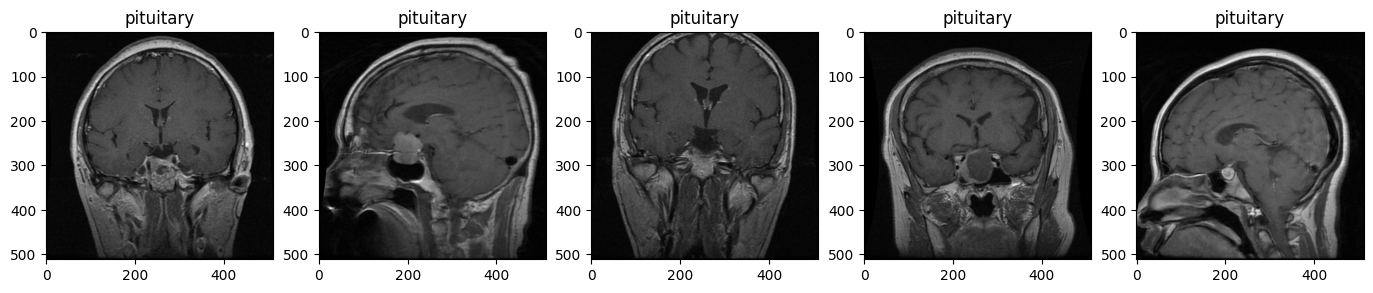

In [5]:
for cls in classes:
  plt.figure(figsize=(17, 17))
  random.shuffle(train_files_path[cls])
  files = train_files_path[cls][:5]

  for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(load_img(files[i]))
    plt.title(cls)
  plt.show()

#### 4. **Data Augmentation**
We preprocess and augment the images for training the machine learning model. We convert the input image to grayscale, apply Gaussian blur, and use thresholding, erosion, and dilation to find the largest contour. We then crop the image to the bounding box of this contour.

In [6]:
def crop_image(image):
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.GaussianBlur(img_gray, (5, 5), 0)
    
    img_thresh = cv2.threshold(img_gray, 45, 255, cv2.THRESH_BINARY)[1]
    img_thresh = cv2.erode(img_thresh, None, iterations=2)
    img_thresh = cv2.dilate(img_thresh, None, iterations=2)

    contours = cv2.findContours(img_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    c = max(contours, key=cv2.contourArea)

    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            
    
    return new_image

In [37]:
test_data_dir = '../frederick/unprocessed_test'
train_class_paths = [os.path.join(data_dir, cls) for cls in classes]
test_class_paths = [os.path.join(test_data_dir, cls) for cls in classes]

The function crop_img_saver takes these paths, reads images, crops them using crop_image, resizes the cropped images to 224x224 pixels, and saves them in specified directories. This function is applied to both the training and testing datasets, organizing the cropped images into corresponding directories.

In [9]:
def crop_img_saver(class_read_paths, save_dir):
  save_root = 'content'
  for cls in class_read_paths:
    for i, p in tqdm(enumerate(os.listdir(cls))):
      path = os.path.join(cls, p)
      img = crop_image(cv2.imread(path))

      if img is not None:
        img = cv2.resize(img, (224, 224))
        save_class = cls.split('\\')[-1]
        save_path = os.path.join(save_root, save_dir, save_class, f'{str(i)}.jpg')
        cv2.imwrite(save_path, img)

In [38]:
crop_img_saver(train_class_paths, save_dir='Train-Data')
crop_img_saver(test_class_paths, save_dir='Test-Data')

0it [00:00, ?it/s]

120it [00:00, 144.57it/s]
120it [00:01, 111.89it/s]
120it [00:00, 185.33it/s]
120it [00:00, 151.11it/s]


`ImageDataGenerator` is used for training data augmentation, specifying parameters like rotation, width/height shift, shear, zoom, horizontal flip, and fill mode. It splits the training data into training and validation subsets. We generate batches of augmented training and validation data, as well as test data, all resized to 224x224 pixels. These generators are ready to be fed into a machine learning model for training and evaluation.

In [39]:
train_data_generator = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_data = train_data_generator.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_data = train_data_generator.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test_data_generator = ImageDataGenerator()

test_data = test_data_generator.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    class_mode='categorical'
)

Found 480 images belonging to 4 classes.


In [28]:
print(train_data.class_indices, test_data.class_indices, sep='\n')

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


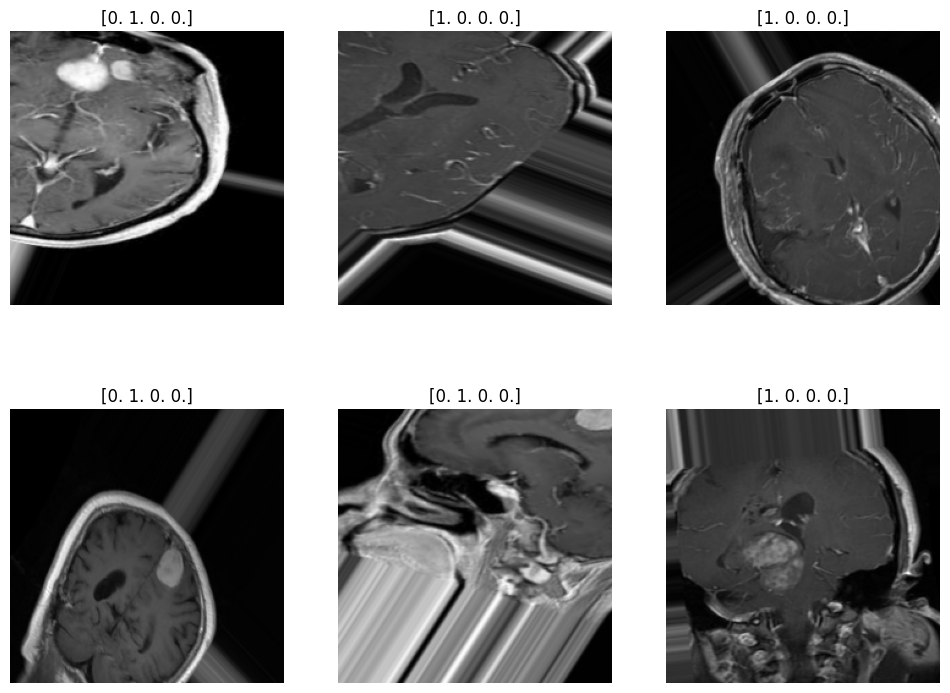

In [16]:
sample_x, sample_y = next(train_data)

plt.figure(figsize=(12, 9))

for i in range(6):
  plt.subplot(2, 3, i+1)
  plt.axis('off'), plt.grid(False)
  plt.imshow(array_to_img(sample_x[i]))
  plt.title(sample_y[i])

##### 5. Build the model
We create the deep learning model using EfficientNetB1. We load the EfficientNetB1 model with pre-trained ImageNet weights, excluding the top fully connected layers to allow for custom classification layers and setting the input image dimensions to 224x224 pixels with three color channels (RGB). 

The output of the EfficientNetB1 model is passed through a GlobalAveragePooling2D layer to condense each feature map to a single value, followed by a Dropout layer with a rate of 0.5 to mitigate overfitting by randomly setting 50% of the input units to 0 during training. 

A Dense layer with four units and a softmax activation function is added to perform the final classification, indicating the model will predict one of four classes.

The Model function then defines the new model, with the EfficientNetB1 input and the final dense layer output. Finally, the model summary is printed to display the architecture, including each layer, its output shape, and the number of parameters, providing an overview of the model's structure.

In [17]:
effnet = EfficientNetB1(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model = effnet.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(4, activation='softmax')(model)
model = Model(inputs=effnet.input, outputs=model)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 6,580,363 (25.10 MB)

 Trainable params: 6,518,308 (24.87 MB)

 Non-trainable params: 62,055 (242.41 KB)

##### 6. Train the model
We compile the model with the Adam optimizer at a learning rate of 0.0001, using categorical cross-entropy as the loss function, and accuracy as the evaluation metric. Three callbacks are then defined to enhance the training process: 
- EarlyStopping monitors validation accuracy and stops training if it doesn't improve for 5 consecutive epochs to prevent overfitting; 
- ModelCheckpoint saves the model only when the validation accuracy improves, ensuring the best model is retained; and 
- ReduceLROnPlateau reduces the learning rate by a factor of 0.2 if the validation loss does not improve for 2 consecutive epochs, with a minimum learning rate of 0.000001, helping the model to converge more efficiently. 

Finally, the model is trained using the fit method with the training data, for 20 epochs, incorporating the validation data and the defined callbacks, and displaying detailed training progress in the output.

In [18]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    mode='auto',
    verbose=1
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'model_ckpt.model.keras', 
    monitor='val_accuracy',
    save_best_only=True,
    mode='auto',
    verbose=1
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,
    patience=2, 
    min_lr=1e-4,
    verbose=1
)

In [19]:
history = model.fit(
    train_data, 
    epochs=20, 
    validation_data=validation_data, 
    callbacks=[checkpoint, early_stopping, reduce_lr], 
    verbose=1
)

Epoch 1/20


C:\Users\Mirza Anaqi\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.2363 - loss: 1.5010
Epoch 1: val_accuracy improved from -inf to 0.38202, saving model to model_ckpt.model.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 208s 10s/step - accuracy: 0.2415 - loss: 1.4946 - val_accuracy: 0.3820 - val_loss: 1.3730 - learning_rate: 1.0000e-04
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.4913 - loss: 1.1624
Epoch 2: val_accuracy improved from 0.38202 to 0.48315, saving model to model_ckpt.model.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 111s 9s/step - accuracy: 0.4944 - loss: 1.1580 - val_accuracy: 0.4831 - val_loss: 1.3079 - learning_rate: 1.0000e-04
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.6599 - loss: 0.9482
Epoch 3: val_accuracy did not improve from 0.48315
12/12 ━━━━━━━━━━━━━━━━━━━━ 115s 9s/step - accuracy: 0.6607 - loss: 0.9468 - val_accuracy: 0.4719 - val_loss: 1.2644 - learning_rate: 1.0000e-04
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7203 - loss: 0.8038
Epoch 4:

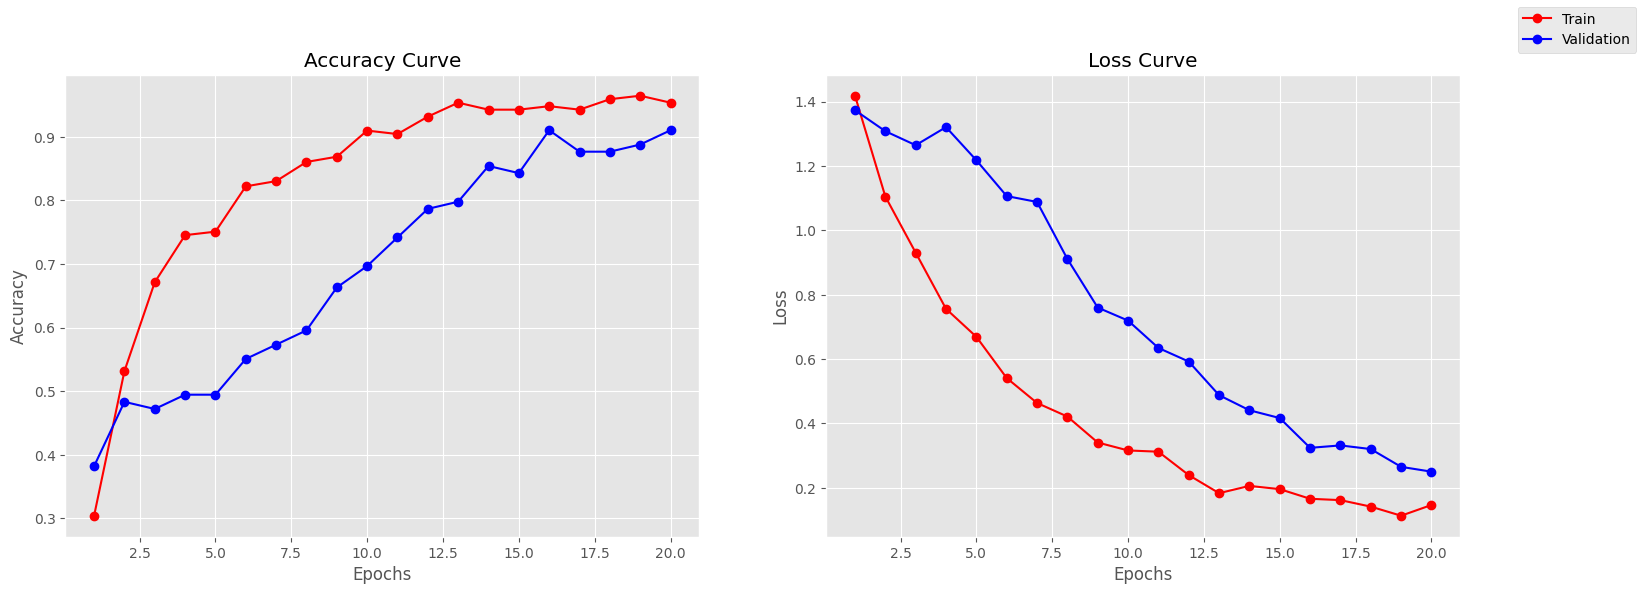

In [20]:
plt.style.use('ggplot')
figure = plt.figure(figsize=(18, 6))
epochs = range(1, 21)

plt.subplot(121)
plt.plot(epochs, history.history['accuracy'], 'ro-')
plt.plot(epochs, history.history['val_accuracy'], 'bo-')
plt.xlabel('Epochs'), plt.ylabel('Accuracy'), plt.title('Accuracy Curve')

plt.subplot(122)
plt.plot(epochs, history.history['loss'], 'ro-')
plt.plot(epochs, history.history['val_loss'], 'bo-')
plt.xlabel('Epochs'), plt.ylabel('Loss'), plt.title('Loss Curve')

figure.legend(['Train', 'Validation'])

##### 7. Evaluation

In [40]:
eval_results = model.evaluate(test_data)
print(f'Test Loss: {eval_results[0]}\nTest Accuracy: {eval_results[1]}')

C:\Users\Mirza Anaqi\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.8505 - loss: 0.4303
Test Loss: 0.4201383590698242
Test Accuracy: 0.84375


C:\Users\Mirza Anaqi\AppData\Local\Temp\ipykernel_19924\848841351.py:5: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  test_steps_per_epoch = np.math.ceil(test_data.samples / test_data.batch_size)


15/15 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step


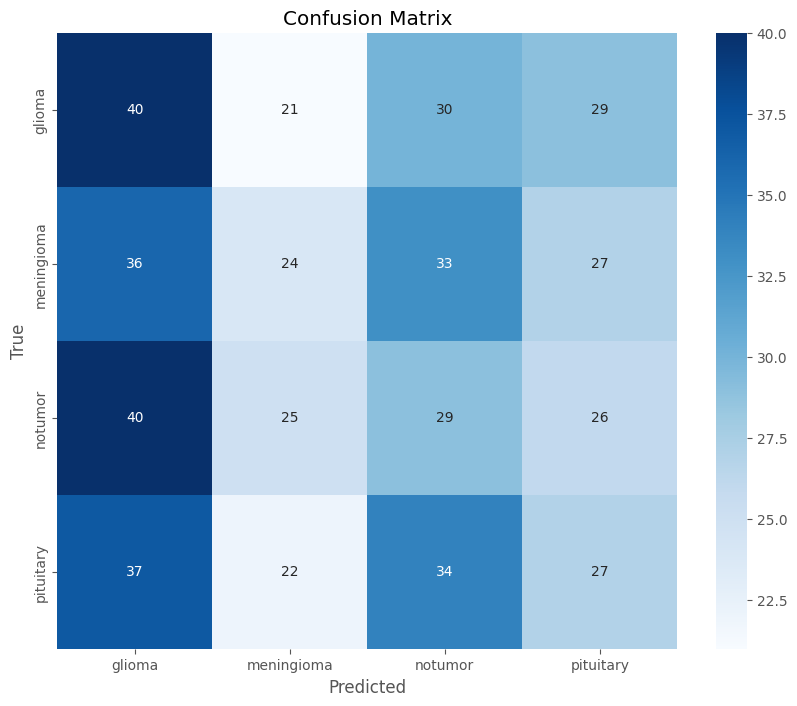

Classification Report
              precision    recall  f1-score   support

      glioma       0.26      0.33      0.29       120
  meningioma       0.26      0.20      0.23       120
     notumor       0.23      0.24      0.24       120
   pituitary       0.25      0.23      0.24       120

    accuracy                           0.25       480
   macro avg       0.25      0.25      0.25       480
weighted avg       0.25      0.25      0.25       480



In [44]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns

# Generate predictions
test_steps_per_epoch = np.math.ceil(test_data.samples / test_data.batch_size)
predictions = model.predict(test_data, steps=test_steps_per_epoch)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys())

# Plot Confusion Matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print('Classification Report')
print(report)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Model prediction probabilities: [[0.01023481 0.02982765 0.95380497 0.0061326 ]]
Output Class Label: 2
Predicted Class: notumor


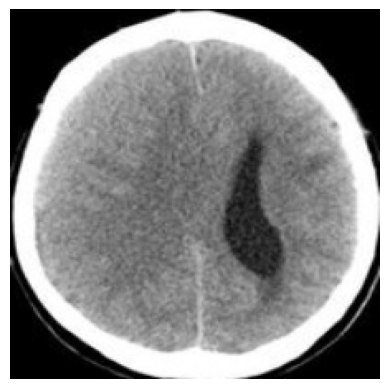

In [42]:
label_map = {v: k for k, v in test_data.class_indices.items()}

test_image_path = 'content/Test-Data/notumor/20.jpg'
test_image = cv2.imread(test_image_path)
plt.grid(False), plt.axis('off')
plt.imshow(test_image)
test_image = cv2.resize(test_image, (224, 224))
test_image = np.expand_dims(test_image, axis=0)

pred = model.predict(test_image)
print(f'Model prediction probabilities: {pred}')
pred = np.argmax(pred)
print(f'Output Class Label: {pred}')
pred = label_map[pred]
print(f'Predicted Class: {pred}')